In [1]:
import global_parameters as gp

import argparse
import bz2
from datetime import datetime
import os
import sys
import numpy as np
import math
import copy
import torch
from tqdm import trange

import multiprocessing
import torch.multiprocessing
# torch.multiprocessing.set_sharing_strategy('file_system')
# TODO: When running in server, uncomment this line if needed
import copy as cp

from rainbow_hac.ap_agent import Agent
from rainbow_hac.center_agent import CT_Agent as Controller
from rainbow_hac.game import Decentralized_Game as Env
from rainbow_hac.memory import ReplayMemory
from rainbow_hac.test import test, test_p

In [2]:
class arg():
    id='default'
    seed=123
    active_scheduler=False
    active_accesspoint=True
    history_length_accesspoint=2
    history_length_scheduler=1
    state_dims=gp.NUM_OF_UAV * gp.OBSERVATION_DIMS
    dense_of_uav=gp.NUM_OF_UAV
    previous_action_observable=True
    architecture='canonical_4uav_61obv_3x3_mix'
    # TODO: if select resnet8, obs v8 and dims 4 should be set in gp
    hidden_size=512
    noisy_std=0.3
    user_cluster_scale=20
    noisy_std_controller_exploration=0.5
    atoms=51
    atoms_sche=21
    T_max=int(50e6)
    V_min=-2
    V_max=2
    # TODO: Make sure the value located inside V_min and V_max
    epsilon_min=0.0
    epsilon_max=0.0
    epsilon_delta=0.0001
    # TODO: Set the ep carefully
    action_selection='greedy'
    model='/home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy'
    # model='/home/k1755742/Alpha-VR-/ap_fed_large_15_28res_1'
    memory_capacity_accesspoint=int(12e3)
    memory_capacity_scheduler=int(12e3)
    replay_frequency=4
    replay_frequency_scheduler=4
    priority_exponent=0.5
    priority_weight=0.4
    multi_step_accesspoint=3
    multi_step_scheduler=3
    discount=0.9
    target_update=int(8000)
    reward_clip=1
    learning_rate=0.0000625
    adam_eps=1.5e-4
    batch_size=32
    better_indicator=1.0
    # TODO: Switch interval should not be large
    learn_start=int(200)
    learn_start_scheduler=int(200)
    evaluate=True
    data_reinforce=True
    # TODO: Change this after debug
    evaluation_interval=1000000
    evaluation_episodes=3000
    # TODO: Note that DeepMind's evaluation method is running the latest agent for 500K frames ever every 1M steps
    # TODO: Change this after debug
    evaluation_size=20
    # TODO: This evaluation_size is used for Q value evaluation, can be small if Q is not important
    enable_cudnn=False
    checkpoint_interval=0
    memory=None
    disable_bzip_memory=True
    # TODO: Change federated round each time
    federated_round=20
    device='cpu'


args = arg()
gp.UE_SCALE = 100
np.random.seed(args.seed)
torch.manual_seed(np.random.randint(1, 10000))

In [3]:
env = Env(args)
env.reset()
print(gp.UE_SCALE)
action_space = env.get_action_size()
scheduling_size = env.get_resource_action_space()
number_of_aps = len(env.accesspoint_list)

20.0


In [4]:
env.center_server.centralized_clustering()
env.center_server.popularity_count_PF_clustered_channel_weighted()
actual_action = env.form_popularity(env.obtain_action_from_popularity())
print(actual_action)
for index, tensor_obs in enumerate(env.get_observation_tensor()):
    env.state_buffer[index].append(tensor_obs)
    env.state_buffer[index].append(tensor_obs)
    env.state_buffer[index].append(tensor_obs)
plot_color_observation(torch.stack(list(env.state_buffer[4])), 'temp', False)

[71, 41, 68, 69, 70, 66, 56, 65, 59, 58, 95, 133, 134, 132, 143, 121, 123, 124, 125, 122, 149, 151, 148, 160, 184, 147, 172, 159, 183, 171, 255, 241, 242, 243, 251, 244, 227, 263, 257, 245]


NameError: name 'plot_color_observation' is not defined

In [5]:
controller = Controller(args, env)
dqn = []
for _ in range(number_of_aps):
    # dqn.append(temp)
    dqn.append(Agent(args, env, _))
    dqn[_].eval()

if args.federated_round > 0:
    global_model = Agent(args, env, "Global_")

Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model0.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model1.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model2.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model3.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model4.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model5.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model6.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model7.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/model8.pth
Loading pretrained model: /home/k1755742/Alpha-VR-/ap_fed_large_20_sim_greedy/modelGlobal_.pth


In [6]:
priority_weight_increase = (1 - args.priority_weight) / (args.T_max - args.learn_start)

In [7]:
env = Env(args)
env.reset()

hidden_vector = []
corrs_state = []
T_rewards_sche = []

sche_state, reward_sum, done = None, [], True
for ind in range(5000):
    if done:
        sche_state, reward_sum, done = env.reset(), [], False

    sche_pack, aps_pack, done = env.step(controller, dqn)

    for _ in range(number_of_aps):
        if not aps_pack[1][_] == -1:
            if np.random.rand() < 0.1:
                corrs_state.append(aps_pack[0][_])
    
    reward_sum.append(aps_pack[2])
    if done:
        final = env.get_finial_reward()
        T_rewards_sche.append(final)
        reward_sum = np.mean(reward_sum, axis=0)
        print(final, end=', ')
        
env.close()

0.6846662809796451, 1.6764951423384602, 3.786070210932524, 1.3981833220542896, 2.0071079458176233, 

KeyboardInterrupt: 

In [ ]:
#Import numpy
import numpy as np

#Import scikitlearn for machine learning functionalities
import sklearn
from sklearn.manifold import TSNE 
from sklearn.datasets import load_digits # For the UCI ML handwritten digits dataset

# Import matplotlib for plotting graphs ans seaborn for attractive graphics.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import seaborn as sb

def plot_observation(observation: np.ndarray, save=False):
    split = int(math.ceil(gp.ACCESS_POINTS_FIELD / gp.SQUARE_STEP)) * gp.OBSERVATION_DIMS
    observation = torch.split(observation, split, dim=1)
    observation = [observation[x][_, :, :].numpy() for _ in range(args.history_length_accesspoint) for x in range(gp.NUM_OF_UAV)]
    
    data_list = []
    for ele in observation:
        each_obv = np.split(ele, gp.OBSERVATION_DIMS)
        for el in each_obv:
            data_list.append(el)

    fig = plt.figure(figsize=(gp.IMAGE_SIZE[0] * gp.NUM_OF_UAV * gp.OBSERVATION_DIMS,
                              gp.IMAGE_SIZE[1] * args.history_length_accesspoint), tight_layout=True)
    ax_list = []
    for index_i in range(gp.NUM_OF_UAV * gp.OBSERVATION_DIMS * args.history_length_accesspoint):
        ax_list.append(fig.add_subplot(args.history_length_accesspoint, gp.NUM_OF_UAV * gp.OBSERVATION_DIMS, index_i + 1))
    im_list = [None for _ in range(gp.NUM_OF_UAV * gp.OBSERVATION_DIMS * args.history_length_accesspoint)]

    for index, data in enumerate(data_list):
        pc_kwargs = {'cmap': 'binary', 'edgecolors': 'k', 'linewidths': 2}
        ax_list[index].set_title(
            "Observation {a} for time {b}".format(a=index % gp.OBSERVATION_DIMS, b=index % (gp.OBSERVATION_DIMS * gp.NUM_OF_UAV)))
        ax_list[index].grid(color='k', linestyle='-', linewidth=1)
        im_list[index] = ax_list[index].pcolor(data, vmin=-1, vmax=1, **pc_kwargs)
        plt.setp(ax_list[index])
        
        bbox_kwargs = {'fc': 'w', 'alpha': .75, 'boxstyle': "round4"}
        ann_kwargs = {'xycoords': 'axes fraction', 'textcoords': 'offset points', 'bbox': bbox_kwargs}
        ax_list[index].annotate('AP', xy=(0.5, 0.5), xytext=(0, 0),
                                    ha='center', va='center', rotation=0, **ann_kwargs)

    if save:
        fig.suptitle(title, fontsize=16)
        plt.savefig("./fig/decision/" + title + ".eps")
        

def plot_color_observation(observation: np.ndarray, title, save=False):
    split = int(math.ceil(gp.ACCESS_POINTS_FIELD / gp.SQUARE_STEP)) * gp.OBSERVATION_DIMS
    observation = torch.split(observation, split, dim=1)
    observation = [observation[x][1, :, :].numpy() * (x+1) * 0.25 for x in range(gp.NUM_OF_UAV)]

    data_end = np.ones((31,31)) * -10
    for ele in observation:
        each_obv = np.split(ele, gp.OBSERVATION_DIMS)
        for el in each_obv:
            data_end = np.maximum(data_end, el)
    data_end[data_end == -10] = 0

    fig = plt.figure(figsize=(8,8), tight_layout=True)
    ax = plt.subplot(aspect='equal')
    sc = ax.pcolor(data_end ,vmin=-0.1, vmax=1, edgecolors='k', linewidths=1)
    
    if save:
        fig.suptitle(title, fontsize=16)
        plt.savefig("./fig/decision/" + title + ".eps")

In [8]:
print(len(hidden_vector))
print(len(corrs_state))
hidden_vector[0].shape

3683
3683


torch.Size([4992])

In [129]:
# save the observation and hidden_vector
import pickle 
pickle.dump(corrs_state, open('./fig/decision/corrs_state.obj', 'wb'))
pickle.dump(hidden_vector, open('./fig/decision/hidden_vector.obj', 'wb'))

In [53]:
# load the saved observation and hidden vector
import pickle 
corrs_state = pickle.load(open('./fig/res/corrs_state.obj', 'rb'))
hidden_vector = pickle.load(open('./fig/res/hidden_vector.obj', 'rb'))

In [55]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

random_select = []
random_select_action = []
random_obs = []
for index, ele in enumerate(hidden_vector):
    # ele = skimage.measure.block_reduce(np.expand_dims(ele, axis=0), (1,4), np.max)[0]
    # if ele[0] < 0.02 and ele[1] < 0.02:
    random_select.append(ele)
    random_obs.append(corrs_state[index])
    for i in range(gp.NUM_OF_UAV):
        if corrs_state[index][1,i*124+31+15,15] == 1:
            random_select_action.append(i)
print(len(random_select))
        
X = np.vstack([random_select[i] for i in range(len(random_select))])
pca = PCA(n_components=2)
X = pca.fit_transform(X)
digits_final = TSNE(2, perplexity=20).fit_transform(X)

4081


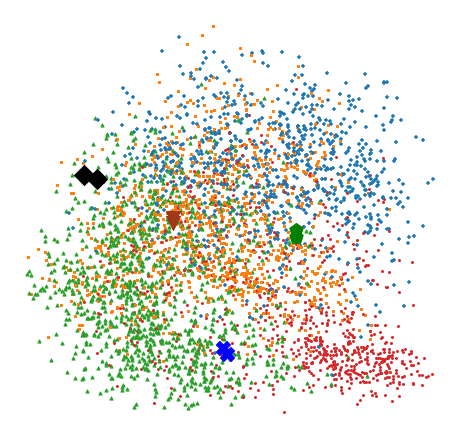

In [62]:
palette = np.array(sb.color_palette("hls", 10))  #Choosing color palette 

# Create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
cmap = matplotlib.cm.get_cmap('tab10')
marker = ['+', 's', '^', '.']
size = [15, 6, 10, 15]
for ele, col in zip(X, random_select_action):
    sc = ax.scatter(ele[0], ele[1], s=size[col], color=cmap(col), marker=marker[col])
# sc = ax.scatter(X[:,0], X[:,1], s=6, c=random_select_action, cmap='tab10')
plt.axis('off')

# # group_0
sc = ax.scatter(X[[777, 2006],0], X[[777, 2006],1], s=200, marker="X", c='b')
# # group_1
sc = ax.scatter(X[[575, 898],0], X[[575, 898],1], s=200, marker="D", c='k')
# # group_2
sc = ax.scatter(X[[469, 559],0], X[[469, 559],1], s=200, marker="p", c='g')
# # group_3
sc = ax.scatter(X[[696, 2153],0], X[[696, 2153],1], s=200, marker="v", c='#a03819')
# # Add the labels for each digit.
f.savefig("./fig/TSNR2d.eps")

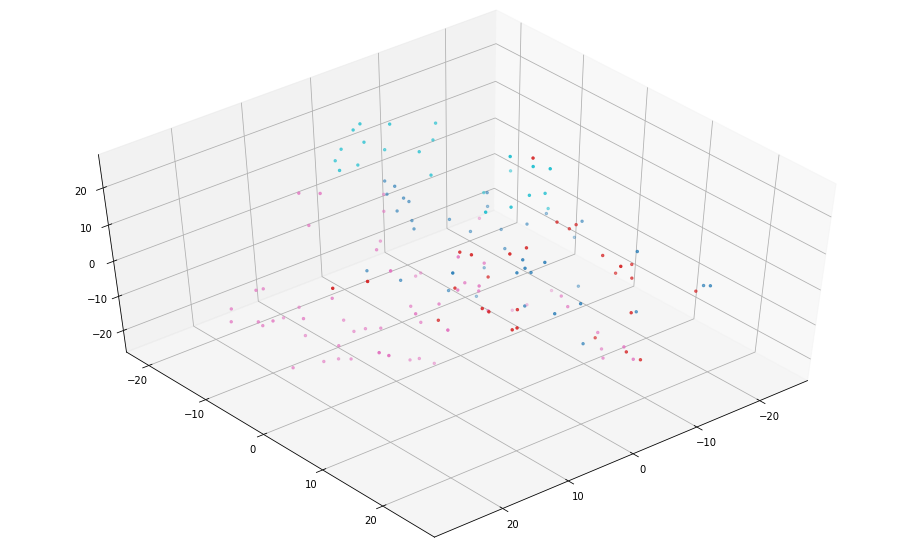

In [52]:
from mpl_toolkits.mplot3d import Axes3D 

# Create a scatter plot.
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2], s=6, c=random_select_action, cmap='tab10')
# plt.axis('off')

# # group_0
# sc = ax.scatter(X[[777, 2006],0], X[[777, 2006],1], X[[777, 2006],2], s=200, marker="X", c='b')
# # group_1
# sc = ax.scatter(X[[575, 898],0], X[[575, 898],1], X[[575, 898],2], s=200, marker="D", c='k')
# # group_2
# sc = ax.scatter(X[[469, 559],0], X[[469, 559],1], X[[469, 559],2], s=200, marker="p", c='g')
# # group_3
# sc = ax.scatter(X[[696, 2153],0], X[[696, 2153],1], X[[696, 2153],2], s=200, marker="v", c='#a03819')
# # Add the labels for each digit.
# # f.savefig("./fig/TSNR.eps")
ax.view_init(50, 50)
plt.draw()
# f.savefig("./fig/TSNR3d.eps")

In [90]:
a = 696
b = 2153
print(str(a),X[a,0],X[a,1],X[a,2], sep='_')
print(str(b),X[b,0],X[b,1],X[b,2], sep='_')
len(hidden_vector)

696_-6.3759384_2.944506_2.4344115
2153_-6.376701_3.5775304_2.3402874


4081

In [38]:
nearest = -1
nearest_dis = 10
search_ind = 243

for index, ele in enumerate(X):
    if index != search_ind:
        dis = math.sqrt(math.pow(ele[0]-X[search_ind,0], 2) + math.pow(ele[1]-X[search_ind,1], 2) + math.pow(ele[2]-X[search_ind,2], 2))
        if dis < nearest_dis:
            nearest = index
            nearest_dis = dis
nearest

515

In [157]:
len(random_select[6])

624

In [36]:
split = int(math.ceil(gp.ACCESS_POINTS_FIELD / gp.SQUARE_STEP)) * gp.OBSERVATION_DIMS
observation = random_obs[177]
observation = torch.split(observation, split, dim=1)
observation = [observation[x][_, :, :].numpy() for _ in range(args.history_length_accesspoint) for x in range(gp.NUM_OF_UAV)]

data_list = []
for ele in observation:
    each_obv = np.split(ele, gp.NUM_OF_UAV)
    for el in each_obv:
        data_list.append(el)

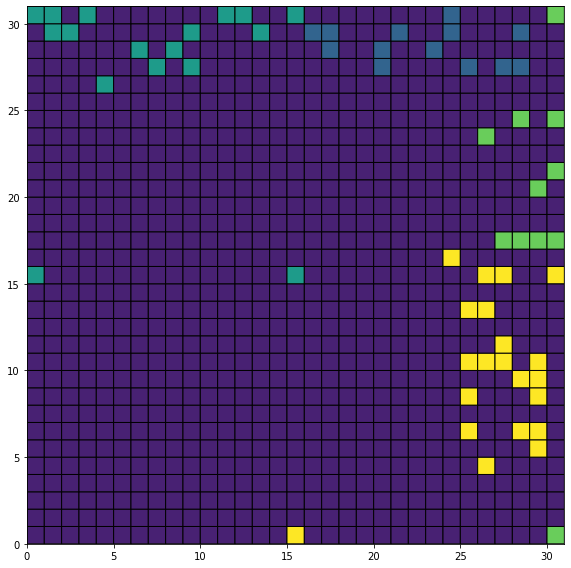

In [39]:
split = int(math.ceil(gp.ACCESS_POINTS_FIELD / gp.SQUARE_STEP)) * gp.OBSERVATION_DIMS
observation = random_obs[515]
observation[observation > 0] = 1
observation = torch.split(observation, split, dim=1)
observation = [observation[x][1, :, :].numpy() * (x+1) * 0.25 for x in range(gp.NUM_OF_UAV)]

data_end = np.ones((31,31)) * -10
for ele in observation:
    each_obv = np.split(ele, gp.OBSERVATION_DIMS)
    for el in each_obv:
        data_end = np.maximum(data_end, el)
data_end[data_end == -10] = 0

fig = plt.figure(figsize=(8,8), tight_layout=True)
ax = plt.subplot(aspect='equal')
sc = ax.pcolor(data_end ,vmin=-0.1, vmax=1, edgecolors='k', linewidths=1)

torch.Size([2, 124, 31])

In [36]:
data_list[1]
fig = plt.figure(figsize=(8,8), tight_layout=True)
ax = plt.subplot(aspect='equal')
sc = ax.pcolor(data_list[243] ,vmin=-1, vmax=1)

NameError: name 'data_list' is not defined

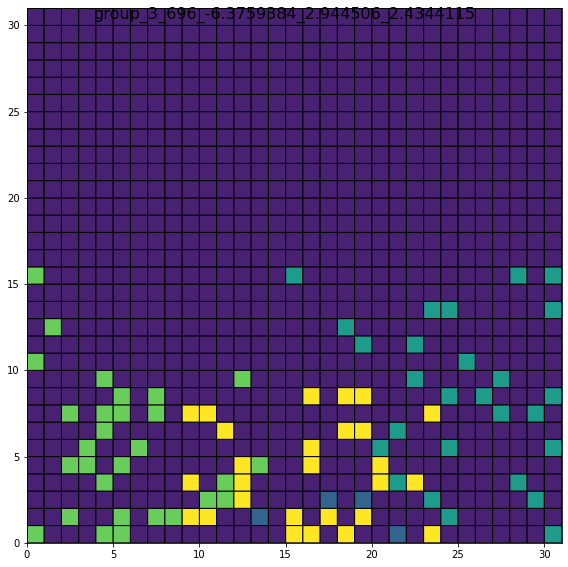

In [92]:
plot_color_observation(random_obs[696], 'group_3_696_-6.3759384_2.944506_2.4344115', True)
#696_-6.3759384_2.944506_2.4344115


  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  anchor: 2-tuple of floats or {'C', 'SW', 'S', 'SE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or num
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  contains: callable
  facecolor: color
  fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  rasterized: bool or None
  sketch_params: (scale: float, length: float, randomness: float)
  sna

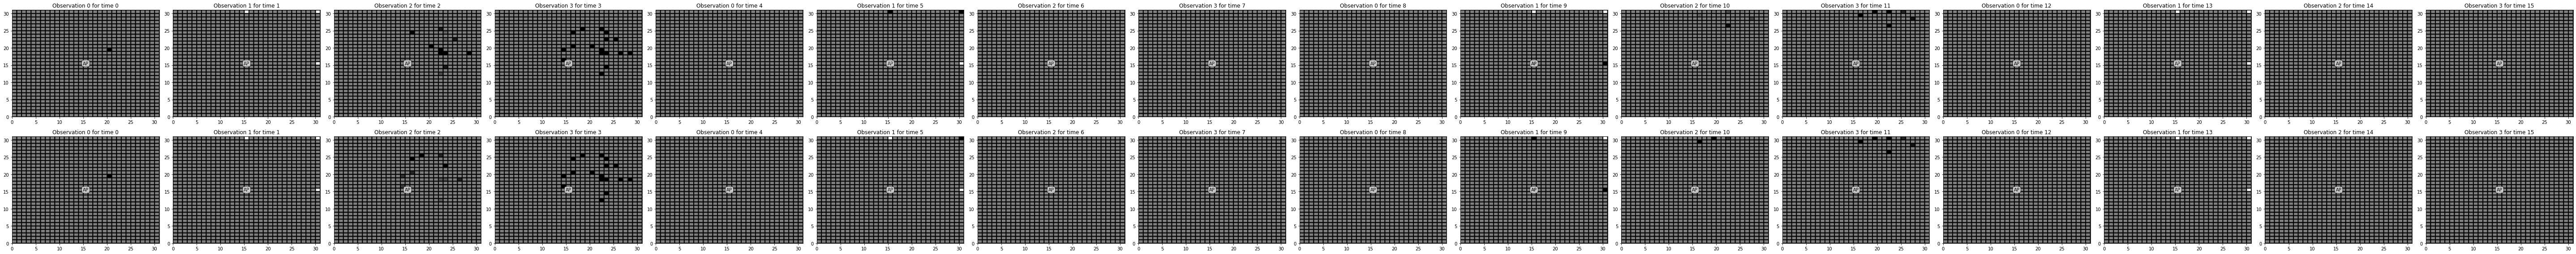

In [48]:
plot_observation(random_obs[777])

In [ ]:
4.404172219394682_12.1885382770376
4.455572822758653_12.316535768642666